# Basic Image Recognition in PyTorch

In [1]:
%pylab inline
!date; hostname; whoami; pwd; curl https://ipinfo.io/hostname; nvidia-smi -L
from imp import reload
from torch import nn, optim
from torch.nn import functional as F
from torchmore import layers, flex
import torch
from torchvision import datasets, transforms
from torchvision.datasets import imagenet
import os.path
from torch.utils import data as torchdata
import helpers

Populating the interactive namespace from numpy and matplotlib
Mon Dec  9 23:12:28 PST 2019
sedna
tmb
/home/tmb/exp/bigdata19
c-67-170-103-104.hsd1.wa.comcast.net
GPU 0: GeForce GTX 1080 Ti (UUID: GPU-2d5cf167-db75-89ec-c6f7-5639237768ce)


# Steps

- load training data from disk
- shuffle the training data
- create batches
- create a model
- create a trainer
- update the weights for each batch

# File Based Datasets

Standard storage format for ImageNet under PyTorch consists of:

- a meta file
- individual image files

In [6]:
for p in "/home/tmb/data/imagenet-raw:/data19/imagenet-raw:/mdata/imagenet-raw".split(":"):
    p += "/ILSVRC2012_devkit_t12"
    if os.path.exists(p):
        devkit_root12 = p
        break
print(devkit_root12)
print(os.popen(f"ls -l {devkit_root12}").read())

/mdata/imagenet-raw/ILSVRC2012_devkit_t12
total 24
-r--r--r-- 1 tmb  tmb  1246 Jun 14  2012 COPYING
dr-xr-xr-x 2 tmb  tmb  4096 Jun 14  2012 data
dr-xr-xr-x 2 tmb  tmb  4096 Jun 14  2012 evaluation
-r--r--r-- 1 tmb  tmb  8479 Jun 14  2012 readme.txt
lrwxrwxrwx 1 root root    8 Dec  9 23:13 train -> ../train
lrwxrwxrwx 1 root root    6 Dec  9 23:13 val -> ../val



# Augmentation

We usually have some kind of augmentation or conversion function.

In [3]:
augmentation_function = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

# Dataset Class

Many datasets have predefined classes that understand the directory layout and metadata format.

In [4]:
training_ds = datasets.ImageNet(devkit_root12, transform=augmentation_function)

# Random Access

Until PyTorch 1.2, all datasets behaved like arrays; at runtime, the image file name is looked up in the metadata and the corresponding image is read.

torch.Size([3, 224, 224]) torch.float32 tensor(0.0039) tensor(1.) 95


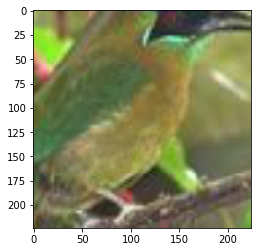

In [5]:
image, cls = training_ds[123456]
print(image.shape, image.dtype, image.min(), image.max(), cls)
imshow(image.permute(1, 2, 0).numpy())

# Data Loader

Datasets are wrapped in `DataLoader` instances; these:
- shuffle the training samples
- create batches out of the training data
- handle multicore preprocessing

In [6]:
training_dl = torchdata.DataLoader(training_ds, batch_size=32, shuffle=True, num_workers=8)

# Data Loaders as Iterators

`DataLoader` instances create iterators over batches composed of random samples.

torch.Size([32, 3, 224, 224]) torch.float32 tensor(0.) tensor(1.) tensor(64) tensor(943)


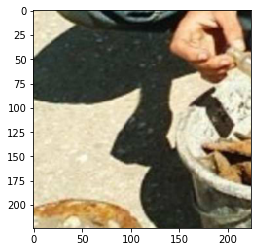

In [7]:
image_batch, cls_batch = next(iter(training_dl))
print(image_batch.shape, image_batch.dtype, image_batch.min(), image_batch.max(), cls_batch.min(), cls_batch.max())
imshow(image_batch[0].permute(1, 2, 0).numpy())

# Model Construction

- PyTorch by default uses direct computation
- models can perform computation directly or be composed of modules
- the `torchmore` library provides useful layers like `layers.Input`

In [8]:
from torchvision import models
def make_model():
    return nn.Sequential(
        layers.Input("BDHW", range=(0, 1), sizes=[(2, 9999), 3, 224, 224]),
        models.resnet18()
    )
model = make_model()
model.cuda();

# Trainers

We usually abstract training into a `Trainer` class: keeps track of model, optimizer, parameters, loss function, history; displays progress.

        class Trainer(object):
            def __init__(self, model): ...
            def train_batch(self, inputs, targets): ...
            def train_for(self, nsamples, dataloader): ...
            def evaluate(self, dataloader): ...
            def set_lr(self, lr): ...

In [9]:
trainer = helpers.Trainer(model)
trainer.set_lr(1e-3)

# Training a Single Batch

This are the main training steps in PyTorch:
- clear gradients
- perform forward step
- compute loss
- propagate gradients backwards
- update the weights (`optimizer.step`)

# Training a Single Batch

In [9]:
!sed '/def train_batch/,/return/!d;/#/d;/set_last/d' helpers.py

    def train_batch(self, images, targets):
        self.optimizer.zero_grad()
        outputs = self.model.forward(images.cuda())
        loss = self.criterion(outputs, targets.cuda())
        loss.backward()
        self.optimizer.step()
        return float(loss)


# Training Loop

Batch training is usually wrapped into a training loop that takes a `DataLoader` instance as an argument.

In [5]:
!sed '/def train_for/,/pass/!d;/display_time/,+2d;/last =/,+1d;/total =/s/=.*/= 0/' helpers.py

    def train_for(self, nsamples, loader, quiet=False):
        total = 0
        while total < nsamples:
            src = iter(loader)
            try:
                while total < nsamples:
                    with self.timers.loading:
                        images, classes = next(src)
                    with self.timers.training:
                        l = self.train_batch(images, classes)
                    total += images.size(0)
                    self.losses.append((total, l))
            except StopIteration:
                pass


# Training

This is the usual training output:
- a plot of the loss
- loading and training times
- NB: loading is much slower than training here, a result of file I/O

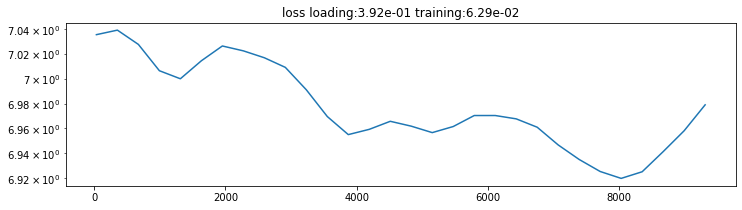

<Figure size 864x216 with 0 Axes>

In [12]:
trainer.train_for(10000, training_dl)
clf()